In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 2.9 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3125612 sha256=efa8a92bca576cf30644ae7ed8603a7f72b20c47e3cd8864fa21fbf2b2d6b0c7
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
!pip install ipdb

     |████████████████████████████████| 790 kB 4.0 MB/s 
     |████████████████████████████████| 374 kB 40.5 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=e0f98a37efb04cb4cd8bdec7a5aa13fa5f54b8bd71d9fda96bd781457a5d50c1
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 4.3 MB/s 


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 7.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import pymorphy2
import re
import random
import fasttext.util
import numpy as np

from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import F1
from torchmetrics.functional import f1, recall
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb

In [ ]:
!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0

--2021-11-25 19:45:50--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-25 19:45:50--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucffe91cb5fbe29220741e9083de.dl.dropboxusercontent.com/cd/0/inline/Bapu4xj1ZUaBv97BkcYqMsqxhWjtpDzLO-AZy90ybaGgX3ic2Pm0wwEyvhnCAQPKPXflIXXtCrz_lVvlFPwhnhpq3VN9sSrT8tMYE7dOgrycHd7gbrD2MNHqPBzqi4gJ2q0PXNQPuPe8e5tdEW8gTPAi/file# [following]
--2021-11-25 19:45:51--  https://ucffe91cb5fbe29220741e9083de.dl.dropboxusercontent.com/cd/0/inline/Bapu4xj1ZUaBv97BkcYqMsqxhWjtpDzLO-AZy90ybaGgX3ic2Pm0wwEyvhnCAQPKPXflIXXtCrz_lVvlFP

In [ ]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [ ]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [ ]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [ ]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [ ]:
def preprocess(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [ ]:
train_sentences.to_csv('train.csv')

In [ ]:
val_sentences.to_csv('val.csv')

In [ ]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 111504


In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 4:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 4 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 4 раз: 17577


In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
      text = text.lower().replace("ё", "е")
      text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
      text = re.sub('@[^\s]+', 'USER', text)
      text = re.sub(' +', ' ', text)
      tokens = text.lower().split()
      tokens = [token.strip(punctuation) for token in tokens]
      return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [ ]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
fasttext.util.download_model('ru', if_exists='ignore')

'cc.ru.300.bin'

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,300)

# Первая модель

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_layer = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams_over_layer(concat)))
        pooling = bigrams.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [ ]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(50)
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
set_random_seed(50)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7407384855406625
Train loss: 0.7125356074037223
Train loss: 0.7026363164186478
Train loss: 0.6974629173844548
Train loss: 0.6942223809860848

Evaluating on train...
Val loss: 0.7275060670716422, Val f1: 0.5808904767036438
Val loss: 0.7025397666569414, Val f1: 0.5596998333930969
Val loss: 0.6942912922664122, Val f1: 0.5556558966636658
Val loss: 0.6897113181776919, Val f1: 0.5549076795578003
Val loss: 0.6872295149274774, Val f1: 0.5548082590103149

Evaluating on test...
Val loss: 0.910044809182485, Val f1: 0.7089211940765381
Val loss: 0.7769347940172467, Val f1: 0.6170817613601685
Val loss: 0.7408149675889448, Val f1: 0.5927575826644897
Val loss: 0.7250056465466818, Val f1: 0.5783572196960449
Val loss: 0.7153457999229431, Val f1: 0.5698594450950623

starting Epoch 1
Training...
Train loss: 0.7272479321275439
Train loss: 0.7014403260987381
Train loss: 0.6926393183794889
Train loss: 0.6881799718080941
Train loss: 0.6853366091444686

Evaluating on train...
Val loss: 0.72189649

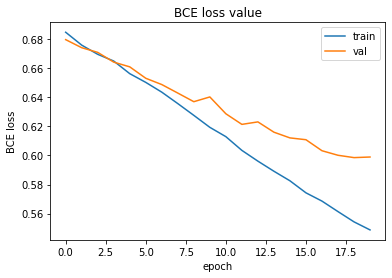

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

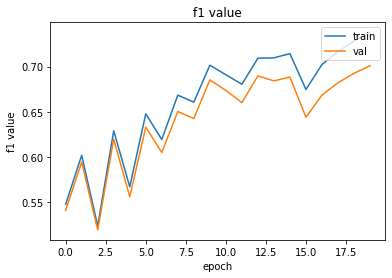

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)

In [ ]:
precision = len(tp)/(len(tp)+len(fp))

In [ ]:
recall = len(tp)/(len(tp)+len(fn))

In [ ]:
f1_score = 2*((precision*recall)/(precision+recall))

In [ ]:
f1_score

0.7015230312035662

# Вторая модель

Чтобы улучшить, сделал дропаут и увеличил размерность эмбеддингов (до 20)

In [ ]:
class CNN_Sequel(nn.Module):
      def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_layer = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
      def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams_over_layer(concat)))
        pooling = bigrams.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits


In [ ]:
model = CNN_Sequel(len(word2id), 20)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
set_random_seed(50)
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
set_random_seed(50)
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)

NameError: ignored

я случайно штуку сверху запустил, все работает, можете сами проверить (сейчас перезапускать мне ничего не хочется, потому что лимт на GPU все и еще скачивать 4.5гб модели fasttext'а -- долго)

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
precision = len(tp)/(len(tp)+len(fp))
recall = len(tp)/(len(tp)+len(fn))
f1_score = 2*((precision*recall)/(precision+recall))
f1_score

0.7308529773738521

Трудно что-то сказать о том, почему он неверно определяет некоторые твитты. Я думаю, просто мало слов и из-за этого недостаточно контекста (может быть, сказывается фильтр, который берет только токена, которые встречаются больше 4 раз)

In [ ]:
shuffle(fp)[:10]

['хуже сайта надо поискать url',
 'user знаю я тогда ждала сильно а сейчас пофиг ',
 'user по пятнице обещали а я до сих пор жду 3 серии подряд типа',
 'спала с десяти до двух днем а сейчас ни в одном глазу',
 'ведь не будет уже такого проекта голос да с такими url',
 'user у меня по ссылке категорически отказывается переводить',
 'user могу тебя на одну завтра но только тебе придется спать на кресле и я с очень и поздно ложимся',
 'user тоже иногда бывают  хотя думаю что сейчас это действительно зря',
 'user мне он наоборот очень ',
 'user какие вот бывает же люди а']

In [ ]:
shuffle(fn)[:10]

['rt user я то думала  что таких уже нет  url',
 'люблю одну нравится другая а хочу быть с третьей нормально вообще',
 'опять смертельно захотела работать в не',
 'rt user почему шоколад такой вкусный',
 'rt user user ты опять злой я телефон отдам тока пароль папки узнаю где песни и фотки ',
 'у  майки   паука   days  блядь ',
 'погуляли как правда чуть не ничего',
 'user тогда понятно но все увы нихера не понимаю в',
 'ахаха уже утро пиздец доброго всем не еще не помню когда в последний раз такую ночь не спал и проебал',
 'блиин вчера же у меня были именины а я со всем забыла']

# Третья модель (пункт II)

In [ ]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 144870


In [ ]:
filtered_vocab = set()

for word in vocab:    
  if vocab[word] > 2:        
    filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 28246


In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [ ]:
char_vocab = Counter()
for char in tweets_data['text']:
    char_vocab.update(list(char))

symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

In [ ]:
len(symbol2id)

340

Сделаем препроц и уберем скобки и всякие другие символы (см. функцию preprocess)

In [ ]:
train_sentences['text'] = train_sentences.apply(lambda row: ' '.join(preprocess(row['text'])), axis=1)

In [ ]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
train_sentences

,text,tone
59549,ебать бывший отвез папу домой спасибо тебе что...,1
99129,кексики и вафельки эхх прощай фигура а еще ж н...,1
53064,качество супер конечно только достал фотик и т...,0
51245,rt user можно вкрутить в транспорты кто дружит...,1
85234,твит новому читателю user пижамка рада тебе,1
...,...,...
36758,user привет привет мне работу в вязальной пред...,1
99338,я его не люблююю нееет просто его глаза улыбка...,0
97469,такие волосы длинные у меня были 2 года прошло...,0
57375,мне бы лишь минуту чтобы понять кто мы друг др...,1


In [ ]:
set_random_seed(50)
train_dataset = WordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

Аналогичный препроц для валидационной выборки

In [ ]:
val_sentences['text'] = val_sentences.apply(lambda row: ' '.join(preprocess(row['text'])), axis=1)

In [ ]:
set_random_seed(50)
val_dataset = WordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
class WordSymbCNN(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # Word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 


        # Symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        

        # Universal layers
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()


    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb_words = torch.mean(embedded_words, dim=1) # считаем средний эмбеддинг предложения
        word_vec = self.dropout(self.word_hidden(mean_emb_words)) # пропускаем эмбеддинг через полносвязный слой 
        word_vec = self.dropout(self.relu(word_vec))
        concat = torch.cat((symb_vec, word_vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [ ]:
model = WordSymbCNN(len(symbol2id), 20, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts, symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
set_random_seed(50)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7468876838684082
Train loss: 0.7113074023148109
Train loss: 0.697239644148133
Train loss: 0.6878040675389565
Train loss: 0.679998941518165

Evaluating on train...
Val loss: 0.6994911219392504, Val f1: 0.7321763038635254
Val loss: 0.676243860146095, Val f1: 0.7062389850616455
Val loss: 0.6682056987827475, Val f1: 0.7004132270812988
Val loss: 0.663784240261983, Val f1: 0.6988243460655212
Val loss: 0.6610845391814774, Val f1: 0.6976481080055237

Evaluating on test...
Val loss: 0.8711917201677958, Val f1: 0.9199808239936829
Val loss: 0.7460022653852191, Val f1: 0.7863978147506714
Val loss: 0.7114907882430337, Val f1: 0.7521045207977295
Val loss: 0.6963154474894205, Val f1: 0.73482346534729
Val loss: 0.6866956635525352, Val f1: 0.7256433963775635

starting Epoch 1
Training...
Train loss: 0.6777452528476715
Train loss: 0.6466206599926126
Train loss: 0.6324724568562075
Train loss: 0.6246585997484498
Train loss: 0.618471211678273

Evaluating on train

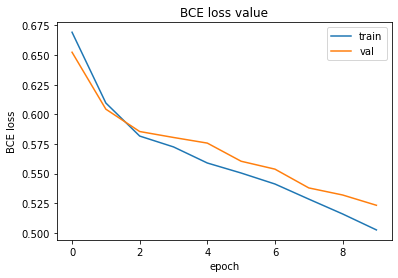

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

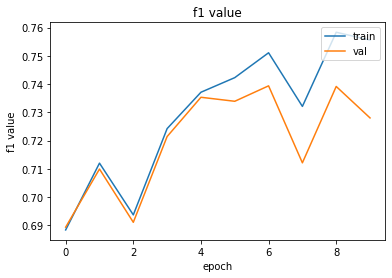

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
precision = len(tp)/(len(tp)+len(fp))
recall = len(tp)/(len(tp)+len(fn))
f1_score = 2*((precision*recall)/(precision+recall))
f1_score

0.7281587897862837

In [ ]:
shuffle(fn)[:10]

['rt user я закрыла дверь в свое сердце и написала входа нет но пришла любовь и сказала я не умею читать url',
 'user user криминал как объяснила маме этот',
 'user с четверти до четверти живут учителя весело',
 'ну или вообще ложиться не буду и в помощь',
 'теперь осталось написать пробный гиа по русскому языку и все хорошо',
 'сегодня на маленькой меня впервые дпс ник я от и ни слова ему даже не сказала только права показала',
 'user почему сразу 3 я подумал',
 'user жень это я собираюсь на журфак а не ты а то еще в газете раньше меня глянь какие у тебя',
 'день был теплый что на удивление особенно мне понравился танец на нг насмеялась от души было весело биология надоело все учить',
 'о боже заставка дисней тот момент когда ты понимаешь что сейчас будет что то охуенное']

In [ ]:
shuffle(fp)[:10]

['user user яка такі і',
 'ну неееет ну пожалуйста у них все так хорошо начиналось моя рассталась со своей любовью',
 'user ахахахах грусть печаль я в вк тебе написала ты игноришь же что общаться два дня будем ахах',
 'rt user что то мегафон сегодня целый вечер тупит',
 'user я понял такие ситуации заставляют людей меняться пусть и за такую цену',
 'user user user а я не думал даже это все все перепутали где и другие будет суд',
 'rt user user оох выздоравливай',
 'user да они в этом году молодцы в отличие от и',
 'user',
 'блин ребята не вы этих жирных пауков которым насрать и на вашу жизнь и здоровье']

# Попытаемся улучшить модель

Добавил еще один линейный слой и увеличил количество эпох до 15, а также вероятность дропаута с 0.5 до 0.7

In [ ]:
class WordSymbCNN_Sequel(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

       # Word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 


        # Symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        

        # Universal layers
        self.linear0 = nn.Linear(in_features=200, out_features=200)
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()


    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb_words = torch.mean(embedded_words, dim=1) # считаем средний эмбеддинг предложения
        word_vec = self.dropout(self.word_hidden(mean_emb_words)) # пропускаем эмбеддинг через полносвязный слой 
        word_vec = self.dropout(self.relu(word_vec))
        concat = torch.cat((symb_vec, word_vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [ ]:
model = WordSymbCNN_Sequel(len(symbol2id), 30, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
set_random_seed(50)
train_dataset = WordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

set_random_seed(50)
val_dataset = WordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
set_random_seed(50)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.5890781155654362
Train loss: 0.565796971321106
Train loss: 0.5564041435718536
Train loss: 0.5530154381768179
Train loss: 0.5510127721606074

Evaluating on train...
Val loss: 0.5985373088291713, Val f1: 0.7826491594314575
Val loss: 0.5780951421836327, Val f1: 0.7540016770362854
Val loss: 0.5715588398955085, Val f1: 0.7457746267318726
Val loss: 0.5679213414757939, Val f1: 0.7432742118835449
Val loss: 0.5658284667375926, Val f1: 0.7405332326889038

Evaluating on test...
Val loss: 0.7628075480461121, Val f1: 0.959463357925415
Val loss: 0.648507331098829, Val f1: 0.8231028318405151
Val loss: 0.6182440952821211, Val f1: 0.7849380970001221
Val loss: 0.6055590828259786, Val f1: 0.7682802677154541
Val loss: 0.5959302908495853, Val f1: 0.7600739002227783

starting Epoch 1
Training...
Train loss: 0.5796563667910439
Train loss: 0.5570156265949381
Train loss: 0.5499517077749426
Train loss: 0.5469803698992325
Train loss: 0.5448511786557533

Evaluating on t

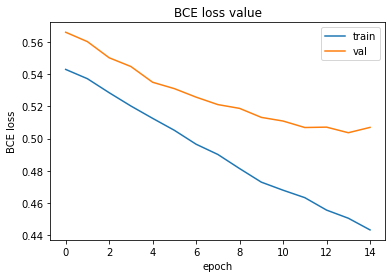

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

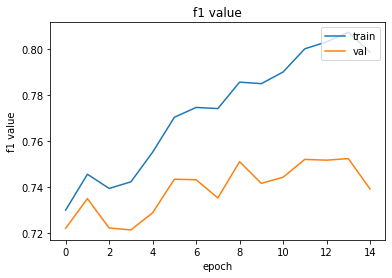

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Даже маленькое улучшение -- это улучшение

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
precision = len(tp)/(len(tp)+len(fp))
recall = len(tp)/(len(tp)+len(fn))
f1_score = 2*((precision*recall)/(precision+recall))
f1_score

0.7392620721506645

Можно было еще конечно не делать препроц и оставить скобки и другие символы. В таком случае, модель бы очень точно определяла тональность твиттов (вплоть до f-score=0.99). Я понимаю, что так можно было сделать, но решил посмотреть можно ли еще как-то поменять параметры модели, чтобы достичь улучшений.